In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

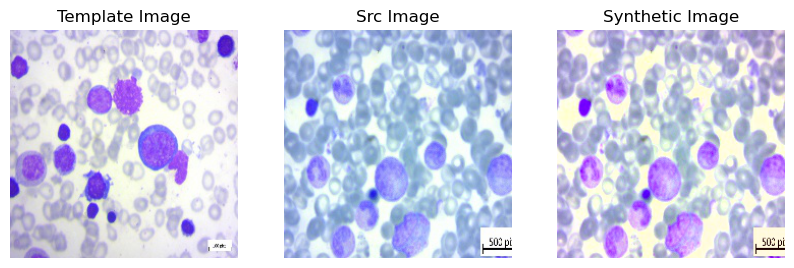

In [86]:
ref_img_path = "data/train/Benign/002.jpg"

def img_norm(src_img, img_template, verbose=False):
  """ Perform color transfer according to the method described 
  by Zhang C, Xiao X, Li X, Chen YJ, Zhen W, Chang J, Zheng C, Liu Z. 
  White blood cell segmentation by color-space-based k-means clustering. 
  Sensors (Basel). 2014 Sep 1;14(9):16128-47
  
  Parameters:
    src_img : array-like
      image to adjust through color transfer
      
    img_template : array-like
      image that would represent a golden standard
  
  Returns:
    img : array-like
      image array of color-adjusted src_img
  
  """
  
  # 1. Transform the RGB color space of the input image and 
  #    the template image to Lab color space
  src_lab = cv2.cvtColor(src_img, cv2.COLOR_BGR2LAB)
  src_lc,src_ac,src_bc = cv2.split(src_lab)
  
  tmp_lab = cv2.cvtColor(img_template, cv2.COLOR_BGR2LAB)
  tmp_lc,tmp_ac,tmp_bc = cv2.split(tmp_lab)
  
  # 2. Compute the mean value and standard deviation of the
  #    input image and the template image in Lab color space
  # 3. Subtract the mean value from all the pixels
  src_lcp = src_lc - np.mean(src_lc)
  src_acp = src_ac - np.mean(src_ac)
  src_bcp = src_bc - np.mean(src_bc)
  
  tmp_lcp = tmp_lc - np.mean(tmp_lc)
  tmp_acp = tmp_ac - np.mean(tmp_ac)
  tmp_bcp = tmp_bc - np.mean(tmp_bc)
  
  # 4. Scale the pixel points of each color component of the 
  #    synthetic image by factors determined by the ratio of 
  #    respective standard deviations
  sig_src_lc = np.std(src_lc)
  sig_src_ac = np.std(src_ac)
  sig_src_bc = np.std(src_bc)
  
  sig_tmp_lc = np.std(tmp_lc)
  sig_tmp_ac = np.std(tmp_ac)
  sig_tmp_bc = np.std(tmp_bc)
  
  img_lc = src_lcp * (sig_tmp_lc / sig_src_lc) + np.mean(tmp_lc)
  img_ac = src_acp * (sig_tmp_ac / sig_src_ac) + np.mean(tmp_ac)
  img_bc = src_bcp * (sig_tmp_bc / sig_src_bc) + np.mean(tmp_bc)
  
  img = np.stack((img_lc, img_ac, img_bc), axis=-1)
  # clip image
  #img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
  img = np.clip(img, 1, 255)
  img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_LAB2RGB)
  
  if verbose:
    fig, axs = plt.subplots(1,3,figsize=(10,5))
    axs[0].imshow(cv2.cvtColor(img_template, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0)
    axs[0].title.set_text('Template Image')
    axs[0].axis('off')
    axs[1].imshow(cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0)
    axs[1].title.set_text('Src Image')
    axs[1].axis('off')
    axs[2].imshow(img.astype(np.float32)/255.0)
    axs[2].title.set_text('Synthetic Image')
    axs[2].axis('off')
    
  return img
  
# retrieve template image
ref_img_path = "data/train/Benign/028.jpg"
img_template = cv2.imread(ref_img_path)
src_img = cv2.imread("data/train/Benign/048.jpg")

_ = img_norm(src_img, img_template, verbose=True)

In [23]:
# call on image pre-processing

def img_seg_rgb(path, verbose=False):
  
  def preprocess_helper(raw_img):
    # apply median blur to reduce image noise
    img = cv2.medianBlur(raw_img, 3)
    
    #img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)
    #img = cv2.equalizeHist(raw_img)
    
    return img
  
  # load image
  raw_img = cv2.imread(path)
  
  # preprocess image with histogram equalization
  pre_img = preprocess_helper(raw_img)
  
  # get green image channel as the one with the most contrast
  green_img = pre_img[:,:,1]
  red_img = pre_img[:,:,2]
  blue_img = pre_img[:,:,0]
  
  # convert green_img to float
  green_img_float = green_img.astype(np.float32)/255.0
  red_img_float = red_img.astype(np.float32)/255.0
  blue_img_float = red_img.astype(np.float32)/255.0
  
  
  # remember the shape of the channel/image
  channel_shape = green_img_float.shape
  
  # vectorize green channel
  vec_green = green_img_float.reshape((-1,1))
  
  # vectorize red channel
  vec_red = red_img_float.reshape((-1,1))
  
  # vectorize blue channel
  vec_blue = blue_img_float.reshape((-1,1))
  
  # start with 3 clusters:
  # 1. background
  # 2. non-target cells
  # 3. target cells
  km_g = KMeans(n_clusters=4, random_state=0, init="k-means++", n_init="auto").fit(vec_green)
  labs_g = np.unique(km_g.labels_)
  
  km_r = KMeans(n_clusters=4, random_state=0, init="k-means++", n_init="auto").fit(vec_red)
  labs_r = np.unique(km_r.labels_)
  
  km_b = KMeans(n_clusters=4, random_state=0, init="k-means++", n_init="auto").fit(vec_blue)
  labs_b = np.unique(km_b.labels_)
  
  if verbose:
    fig, axs = plt.subplots(5,3,figsize=(15,15))
    axs[0,0].imshow(raw_img.astype(np.float32)/255.0)
    axs[0,0].axis('off')
    axs[0,1].imshow(raw_img.astype(np.float32)/255.0)
    axs[0,1].axis('off')
    axs[0,2].imshow(raw_img.astype(np.float32)/255.0)
    axs[0,2].axis('off')
    for i in range(1,5):
      temp_img = np.zeros(vec_green.shape)
      temp_img[km_g.labels_ == labs_g[i-1]] = 1
      axs[i,0].imshow(temp_img.reshape(channel_shape), cmap='gray')
      axs[i,0].axis('off')
      
      temp_img = np.zeros(vec_red.shape)
      temp_img[km_r.labels_ == labs_r[i-1]] = 1
      axs[i,1].imshow(temp_img.reshape(channel_shape), cmap='gray')
      axs[i,1].axis('off')
      
      temp_img = np.zeros(vec_blue.shape)
      temp_img[km_b.labels_ == labs_b[i-1]] = 1
      axs[i,2].imshow(temp_img.reshape(channel_shape), cmap='gray')
      axs[i,2].axis('off')

    plt.show()
  
#   # pick the cluster with highest green intensity (darkest)
#   cl = labs[np.argmax([ np.mean(vec[km.labels_ == lab]) for lab in labs ])]
  
#   if verbose: print("Run 1 k-means cluster with max green intensity:", cl)
  
#   # create mask for highest intensity cluster
#   mask = np.ones(vec.shape)
  
#   mask[(km.labels_ == cl)] = 0
#   mask = mask.reshape(channel_shape)
  
#   # perform second segmentation of cells and nucleus
#   sub_green_img = green_img_float[mask == 1].copy()
#   #green_img_part2[mask == 1] = green_img_float[mask == 1]
  
#   # vectorize green channel
#   vec2 = sub_green_img.reshape((-1,1))
  
#   # start with 2 clusters:
#   # 1. cell outer
#   # 3. nucleus
#   km2 = KMeans(n_clusters=2, random_state=0, init="k-means++", n_init="auto").fit(vec2)
#   labs2 = np.unique(km2.labels_)
  
#   # pick the cluster with the highest intensity
#   cl2 = labs2[np.argmax([ np.mean(vec2[km2.labels_ == lab]) for lab in labs2 ])]
  
#   if verbose: print("Run 2 k-means cluster with max green intensity:", cl2)
  
#   # create mask for highest intensity cluster
#   mask2 = np.zeros(vec.shape)
#   mask2[(km.labels_ != cl)] = 1
#   mask2[np.where(km.labels_ != cl)[0][km2.labels_ != cl2]] = 0.5
  
#   mask2 = mask2.reshape(channel_shape)
  
#   # perform second segmentation of cells and nucleus
#   #green_img_part2 = np.ones(channel_shape)
#   #green_img_part2[mask == 1] = green_img_float[mask == 1]

#   if verbose:
#     fig, axs = plt.subplots(4,1,figsize=(5,15))
#     axs[0].imshow(raw_img.astype(np.float32)/255.0)
#     #axs[0].title.set_text("/".join(p.split('/')[-2:]))
#     axs[0].axis('off')
#     axs[1].imshow(green_img_float, cmap='gray')
#     #axs[1].title.set_text("/".join(p.split('/')[-2:]))
#     axs[1].axis('off')
#     axs[2].imshow(mask, cmap='gray')
#     #axs[2].title.set_text("/".join(p.split('/')[-2:]))
#     axs[2].axis('off')
#     axs[3].imshow(mask2, cmap='gray')
#     #axs[3].title.set_text("/".join(p.split('/')[-2:]))
#     axs[3].axis('off')

#     plt.show()
  
  
  
  
  

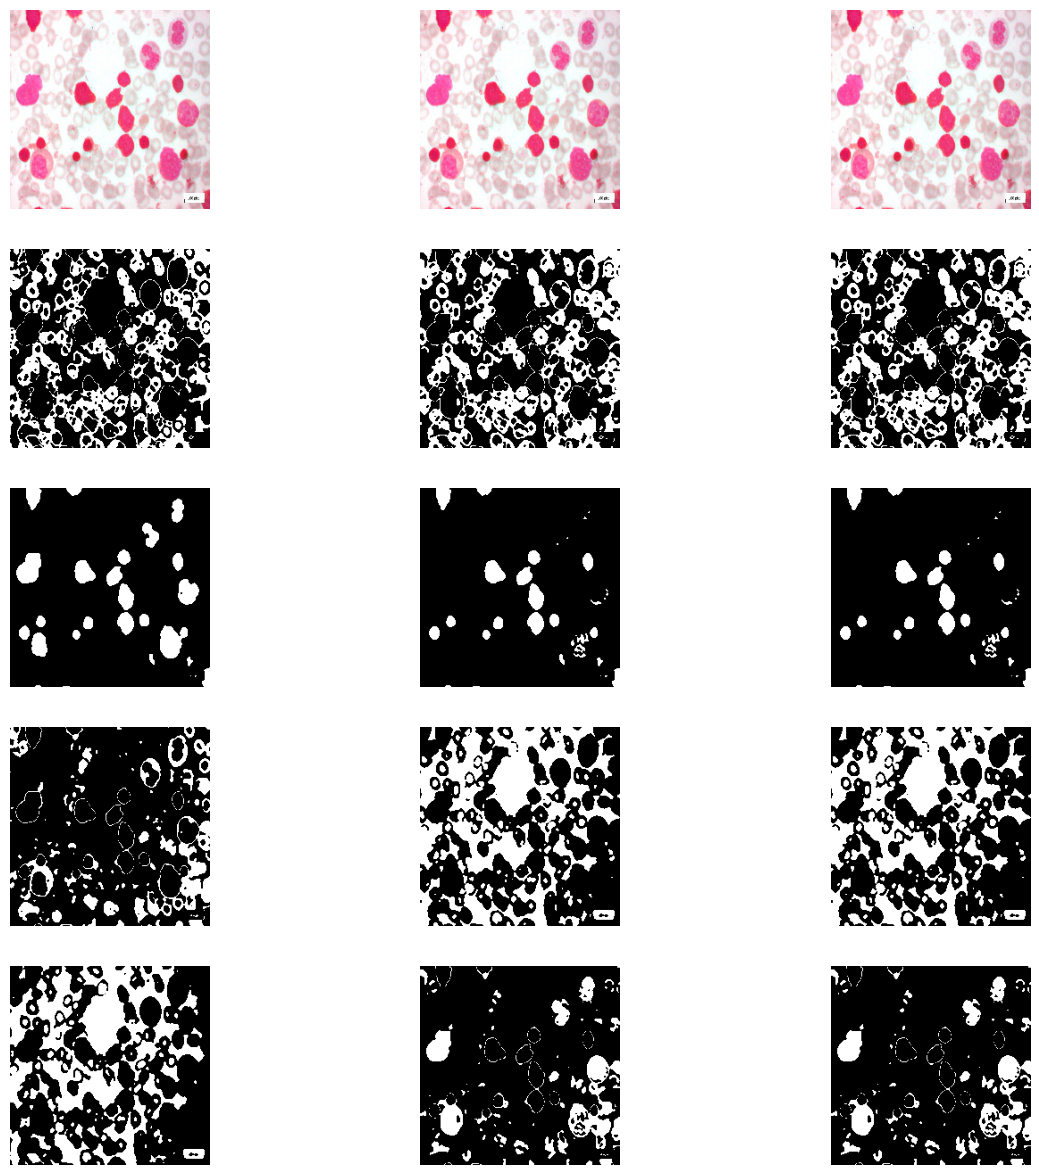

In [26]:
img_seg_rgb('data/train/Benign/001.jpg', verbose=True)

In [14]:
def img_seg_lab(path, verbose=False):
  
  def preprocess_helper(raw_img):
    # apply median blur to reduce image noise
    img = cv2.medianBlur(raw_img, 3)
    
    #img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)
    #img = cv2.equalizeHist(raw_img)
    
    return img
  
  # load image
  raw_img = cv2.imread(path)
  img_shape = raw_img.shape
  channel_shape = raw_img.shape[:2]
  
  # preprocess image with histogram equalization
  pre_img = preprocess_helper(raw_img)
  
  # convert to LAB
  lab_img = cv2.cvtColor(pre_img, cv2.COLOR_BGR2LAB)
  lc,ac,bc = cv2.split(lab_img)

  # vectorize pixels keeping a,b channels
  vec = np.stack((ac,bc), axis=-1).reshape(-1,2)
  
  # k-medoids
  #km = KMedoids(n_clusters=4, init='k-medoids++', method='pam', max_iter=20).fit(vec)
  km = KMeans(n_clusters=4, random_state=0, init="k-means++", n_init="auto").fit(vec)
  labs = np.unique(km.labels_)
  
  if verbose:
    fig, axs = plt.subplots(5,1,figsize=(15,15))
    axs[0].imshow(raw_img.astype(np.float32)/255.0)
    axs[0].axis('off')
    for i in range(1,5):
      temp_img = raw_img.copy().astype(np.float32)/255.0
      temp_img[(km.labels_ != labs[i-1]).reshape(channel_shape),:] = 0
      axs[i].imshow(temp_img, cmap='gray')
      axs[i].axis('off')

    plt.show()

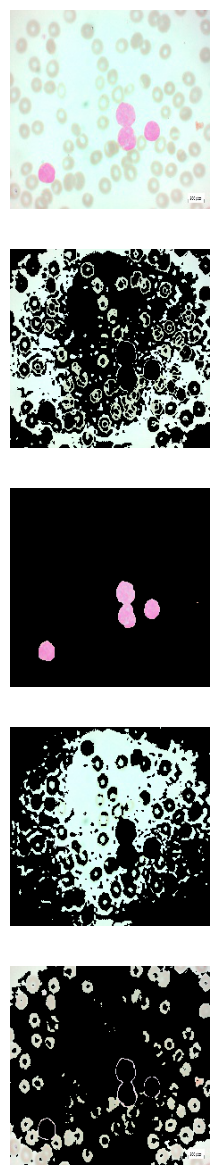

In [29]:
img_seg_lab('data/train/Pro/001.jpg', verbose=True)

In [ ]:
# define base path and Path objects for different image sets
img_path_base = 'data/'
path_train = Path(img_path_base) / 'train/'
path_valid = Path(img_path_base) / 'valid/'
path_test = Path(img_path_base) / 'test/'

train_labels = [ pobj.parts[-1].lower() for pobj in path_train.iterdir() if pobj.is_dir() ]
print("Labels: ", train_labels)

In [ ]:
# image paths for each set
train_set = sorted([ pobj for dobj in train_labels for pobj in (path_train / dobj.title()).iterdir() if (
  pobj.is_file() and str(pobj).endswith('.jpg')) ])

valid_set = sorted([ pobj for dobj in train_labels for pobj in (path_valid / dobj.title()).iterdir() if (
  pobj.is_file() and str(pobj).endswith('.jpg')) ])

test_set = sorted([ pobj for dobj in train_labels for pobj in (path_test / dobj.title()).iterdir() if (
  pobj.is_file() and str(pobj).endswith('.jpg')) ])

In [ ]:
# create temp verification set for preprocessing
ver_set = [ str(pobj) for pobj in train_set if pobj.parts[-1] in ['001.jpg','002.jpg'] ]
ver_set

In [ ]:
# read images, convert to [0, 1] floats
imgs = [ cv2.imread(sobj).astype(np.float32) / 255.0 for sobj in ver_set ]
print("Images value range:",(np.min(imgs[0]), np.max(imgs[0])))

In [ ]:
fig, axs = plt.subplots(4,2,figsize=(10,15))
for i, p in enumerate(ver_set):
  axs[i//2,i%2].imshow(imgs[i])
  axs[i//2,i%2].title.set_text("/".join(p.split('/')[-2:]))
  axs[i//2,i%2].axis('off')
  
plt.show()

In [ ]:
# pre-process images
proc_imgs = [ img_seg(img_path) for img_path in ver_set ]  

In [ ]:
fig, axs = plt.subplots(4,2,figsize=(15,15))
for i, p in enumerate(ver_set):
  axs[i//2,i%2].imshow(proc_imgs[i], cmap='gray')
  axs[i//2,i%2].title.set_text("/".join(p.split('/')[-2:]))
  axs[i//2,i%2].axis('off')
  
plt.show()